# **ML Final Project**
### 1971063 김윤서   

• Task 1: Implement Inception module for CIFAIR-10. (20 points)    
• Task 2: Increase your Test set accuracy. (25 points)    
• Task 3: Find hyper-parameters. (25 points)    
• Task 4: Write report: (30 points)


## 0. CIFAR10 데이터셋 불러오기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

 #train data 용도
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,   
                                        download=True, transform=transform) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size= 8,          #hyper-parameter: batch_size=8
                                          shuffle=True, num_workers=2)
  
  #test data 용도
testset = torchvision.datasets.CIFAR10(root='./data', train=False,    
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size= 8,            #hyper-parameter: batch_size=8
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


## 1. 필요한 함수 정의

#### imshow 함수

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#### train 함수: network Training 

In [5]:
## 1
loss_history = {'train': [], 'val': []}  
accuracy_history = {'train': [], 'val': []}   # 시각화를 위해 loss, acc history 저장용


def train(net, trainloader, max_epoch, crit, opt, model_path='./cifar_net.pth'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            input, label = data
        
            # Training on GPU
            input = input.to(device)
            label = label.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(input)
            loss = crit(outputs, label)
            loss.backward()
            opt.step()

            # 2000회마다 loss 출력
            running_loss += loss.item()
            loss_history['train'].append(loss.item())  #loss_history 저장

            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

#### train_val 함수

#### print_accuracy 함수: 모델 정확도 출력

In [6]:
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' 
          % (total, 100 * correct / total))

#### 시각화 함수: learning curve 그리기

In [7]:

import matplotlib.pyplot as plt

def plot_acc(history, title=None):
  # summarize history for accuracy
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['accuracy'])         # train 데이터로 구한 정확도값
  plt.plot(history['val_accuracy'])     # test 데이터로 구한 정확도값
  if title is not None:
    plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)   # 두 선의 이름(Train, Test) 표시

def plot_loss(history, title=None):
  # summarize history for loss
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['loss'])             # train 데이터로 구한 손실값
  plt.plot(history['val_loss'])         # test 데이터로 구한 손실값
  if title is not None:
    plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)

+ 데이터셋 확인해보기

(36, 274, 3)


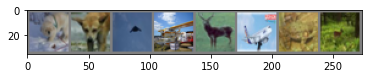

  dog   dog plane plane
torch.Size([3, 32, 32])


In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# print size of single image
print(images[1].shape)

## 2. Inception module 정의


In [9]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

## 3. CNN 모델 정의 
#### Training setup:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 4
* Training epoch: 2


### 모델 1: GoogleNet

In [10]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()

        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)
      

    def forward(self, x):
        
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [11]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
googlenet = GoogLeNet()
googlenet = googlenet.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)

PATH = './google_net.pth'

epochs = 2  #hyper-Parameter

# Train
#train(googlenet, trainloader, epochs, criterion, optimizer, PATH)

In [13]:
# GoogLeNet) Test 결과 출력
#googlenet.load_state_dict(torch.load(PATH))
#print_accuracy(googlenet, testloader)

### 모델 2: GoogleNet 보완해보기 -> MyNet

In [14]:

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),  #hyper-Parameter: filter size = 3
            nn.BatchNorm2d(128),
            nn.ReLU(True),        #활성화 함수 ReLU 사용
        )

        self.a3 = Inception(128,  32,  48,  64,  8, 16, 16)
        self.b3 = Inception(128,  64,  96, 128, 16, 32, 32)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(256, 160,  96, 256, 16,  64,  64)
        self.b4 = Inception(544, 256, 128, 256, 64, 128, 128)
        self.c4 = Inception(768, 256, 128, 256, 64, 128, 128)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a5 = Inception(768, 256, 256, 512, 64, 128, 128)
        self.b5 = Inception(1024, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)  # Average Pooling 사용
        self.linear = nn.Linear(1024, 10)
        

    def forward(self, x):
        
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [15]:

myNet = MyNet()
myNet = myNet.to(device)

# Define a Loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(myNet.parameters(), lr=0.0005, momentum=0.9)

PATH = './my_net.pth'
epochs = 6

# Train
train(myNet, trainloader, epochs, loss_func, optimizer, PATH)

[1,  2000] loss: 1.578
[1,  4000] loss: 1.191
[1,  6000] loss: 0.987
[2,  2000] loss: 0.825
[2,  4000] loss: 0.753
[2,  6000] loss: 0.703
[3,  2000] loss: 0.573
[3,  4000] loss: 0.576
[3,  6000] loss: 0.548
[4,  2000] loss: 0.430
[4,  4000] loss: 0.448
[4,  6000] loss: 0.442
[5,  2000] loss: 0.344
[5,  4000] loss: 0.362
[5,  6000] loss: 0.357
[6,  2000] loss: 0.261
[6,  4000] loss: 0.283
[6,  6000] loss: 0.296
Finished Training
Saved Trained Model


In [16]:
# Test
myNet.load_state_dict(torch.load(PATH))
print_accuracy(myNet, testloader)

Accuracy of the network on the 10000 test images: 84 %


## * hyper-parameter 목록
1. **learning rate** (lr)=0.001, 0.0005, 0.0001, ...   
2. **Batch size**=4,8,16,32   
3. **Epochs**=2,4, ...
4. Network architectures: googLeNet
5. Activation functions: RELU 사용   
6. Loss function: Sotfmax cross entropy   